# Understanding and Predicting Blight Ticket Compliance in the City of Detroit

As part of the University of Michigan's Applied Machine Learning in Python course, we are asked to predict the probability that a blight violation ticket will be paid. The assignments asks for a simple classifier model that can reach an AUROC of 0.7 on the test set, in order to pass. However, I took this opportunity to go more in detail by providing in-depth data analysis and an attempt to reach a higher score. This has given me the chance to explore more topics that were not a part of the scope of this course.

## Introduction 

### What are blight violations?

The City of Detroit currently has a property maintenance code, detailing how properties in the city should be maintained. Property owners can be issued Blight Violation tickets if their property fails to follow these regulations. Blight tickets can be issued by City officials and police officers.

Issuing tickets can be an expensive process that can cost millions of dollars every year, so it's important that violators comply with paying these tickets on time. However, many of these tickets go unpaid and it's a big financial problem for the city. The assignment asks us to develop a model that can determine the probability that a violator will pay the ticket on time. Compliance, in this context, means that the ticket was paid early, on time, or within one month of the hearing date. Based on this model, we can start to understand why people fail to comply.

### Goal

From looking at the course forums, most people tend to score in the 7.5-7.9 range, while a very few manage to reach 0.8+. This is understandable as most students just want to get the minimum score to pass the assignment. My goal will be to reach an AUC score of 0.8+. 

## Data Preparation

The dataset provided consists of blight violation tickets issued between 2004-2011. We are also given a dataset that has the address for each ticket id and a dataset that has the latitude and longitude for each address. We will create a model around this data to predict compliance for 2012-2016 tickets. 

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [41]:
train = pd.read_csv('../data/train.csv', encoding = "ISO-8859-1", low_memory=False)
addresses = pd.read_csv('../data/addresses.csv', encoding = "ISO-8859-1", low_memory=False)
latlons = pd.read_csv('../data/latlons.csv', encoding = "ISO-8859-1", low_memory=False)

In [42]:
addresses = addresses.merge(latlons, left_on='address', right_on='address')
train = train.merge(addresses[['ticket_id', 'lat', 'lon']], left_on='ticket_id', right_on='ticket_id')

In [43]:
print('Train data:', train.shape)

Train data: (250306, 36)


The dataset has a total of 250306 entries! But, we'll have to take a closer look at the data before doing any real analysis.

In [44]:
train.head(3)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,42.326937,-83.135118
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,42.380516,-83.096069


In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250306 entries, 0 to 250305
Data columns (total 36 columns):
ticket_id                     250306 non-null int64
agency_name                   250306 non-null object
inspector_name                250306 non-null object
violator_name                 250272 non-null object
violation_street_number       250306 non-null float64
violation_street_name         250306 non-null object
violation_zip_code            0 non-null float64
mailing_address_str_number    246704 non-null float64
mailing_address_str_name      250302 non-null object
city                          250306 non-null object
state                         250213 non-null object
zip_code                      250305 non-null object
non_us_str_code               3 non-null object
country                       250306 non-null object
ticket_issued_date            250306 non-null object
hearing_date                  237815 non-null object
violation_code                250306 non-null obj

### Missing Values

Our target is compliance, and as we can see it has almost 10000 null values. Null, in this case, actually means that the violator was found not responsible of the blight charges. We are only interested in responsible violators, and whether they complied or not, so we can safely get rid of all the null values for compliance.

In [46]:
train = train[~train.compliance.isnull()]

We also want to get rid of columns with a significant amount of missing values. We'll create a visualization to help us with this process

Text(0.5, 1.0, 'Missing Values')

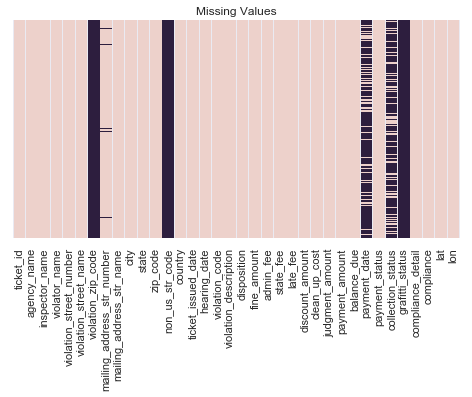

In [47]:
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(train.isnull(), cbar=False, yticklabels=False, ax=ax, cmap=sns.cubehelix_palette(2))
ax.set_title('Missing Values')

We can clearly see 5 columns that we need to get rid of. We don't always have to get rid of columns with missing data, since we can impute values for them based on the remaining data. However, for columns with a vast amount of missing data, imputing values is not productive.

We can also get rid of the ticket_id column since it doesn't tell us anything about a violator's willigness to comply. 

In [48]:
train.drop(['violation_zip_code', 'non_us_str_code', 'payment_date', 'collection_status', 'grafitti_status', 
           'ticket_id'], axis=1, inplace=True)

### Data Types

In [49]:
train.dtypes

agency_name                    object
inspector_name                 object
violator_name                  object
violation_street_number       float64
violation_street_name          object
mailing_address_str_number    float64
mailing_address_str_name       object
city                           object
state                          object
zip_code                       object
country                        object
ticket_issued_date             object
hearing_date                   object
violation_code                 object
violation_description          object
disposition                    object
fine_amount                   float64
admin_fee                     float64
state_fee                     float64
late_fee                      float64
discount_amount               float64
clean_up_cost                 float64
judgment_amount               float64
payment_amount                float64
balance_due                   float64
payment_status                 object
compliance_d

All the datatypes seem to be right. Only thing we'll do here is transform hearing_date and ticket_issued_date to DateTime objects.

In [50]:
train['ticket_issued_date'] = pd.to_datetime(train['ticket_issued_date'], format='%Y-%m-%d %H:%M:%S')
train['hearing_date'] = pd.to_datetime(train['hearing_date'], format='%Y-%m-%d %H:%M:%S')

### Outliers

In [51]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
violation_street_number,159880.0,10713.155166,36231.585165,0.000000,4920.000000,10398.000000,15783.250000,1.415411e+07
mailing_address_str_number,157322.0,9133.713676,36577.294364,1.000000,532.000000,2418.000000,12844.000000,5.111345e+06
fine_amount,159880.0,357.035295,675.655580,0.000000,200.000000,250.000000,250.000000,1.000000e+04
admin_fee,159880.0,20.000000,0.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
state_fee,159880.0,10.000000,0.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01
late_fee,159880.0,33.651512,67.692916,0.000000,10.000000,25.000000,25.000000,1.000000e+03
discount_amount,159880.0,0.195959,4.290344,0.000000,0.000000,0.000000,0.000000,3.500000e+02
clean_up_cost,159880.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
judgment_amount,159880.0,420.650218,742.555062,0.000000,250.000000,305.000000,305.000000,1.103000e+04
payment_amount,159880.0,72.206537,259.849545,0.000000,0.000000,0.000000,0.000000,1.103000e+04


We can see that state_fee, clean_up_cost and admin_fee have the same values for all observations. There's no point in keeping them in our model.

In [52]:
train.drop(['state_fee', 'admin_fee', 'clean_up_cost'], axis=1, inplace=True)

We also notice that fine_amount, discount_amount, late_fee and judgment_amount have outliers. It's important to determine if these outliers are errors or actual possible values. If they're not erroneous, we should keep them in our model.

A quick look at [this website](https://detroitmi.gov/departments/department-appeals-and-hearings/blight-ticket-information) confirms that the maximum fine that can be imposed is 10,000. So, the fine_amount column is not erroneous. Judgment_amount is simply the sum of fine and the fees. Discount amount is a 10% discount that can be applied to the fine_amount. It's usually applied to people who pay their fees early, but it can be arbitrary. Late_fee is a 10% fee that's usually applied to violators who don't pay on time, but it's not always the case.

We also have to see if there are outliers in the datetime values.

In [53]:
train.describe(include=['datetime64[ns]']).transpose()

,count,unique,top,freq,first,last
ticket_issued_date,159880,68097,2007-12-21 09:00:00,60,1988-05-06 20:00:00,2011-12-30 14:20:00
hearing_date,159653,5970,2005-12-20 09:00:00,590,2005-01-27 09:00:00,2016-11-22 09:00:00


As we can see, we have ticket issued dates that go as far as 1988, when it should be restricted to 2004-2011. These are clearly errors in the data and we have to get rid of them.

In [54]:
train = train[train['ticket_issued_date'].apply(lambda x: x.year >= 2004)]

## Exploratory Data Analysis, Feature Engineering and Feature Selection

### Target

Our target is compliance.

Compliance
0.0    92.747015
1.0     7.252985
Name: compliance, dtype: float64


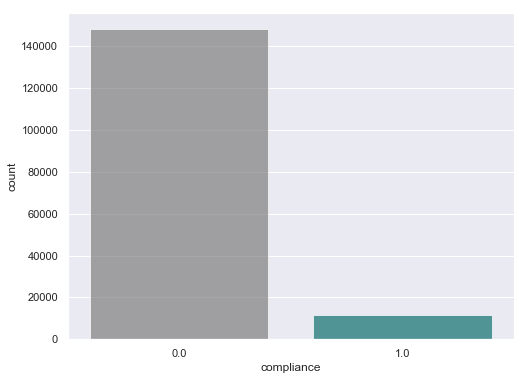

In [55]:
print('Compliance')
print(train['compliance'].value_counts(normalize=True)*100)

fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(train['compliance'], ax=ax, palette=['grey', 'teal'], alpha=0.7)

As we can see, 92% of violators do not comply to paying their tickets on time or at all. It's clearly a big issue. Let's break these down into different categories for compliance.

 late payment more than 1 month     19016
 no payment                        129267
Name: compliance_detail, dtype: int64


Text(0, 0.5, 'Reason')

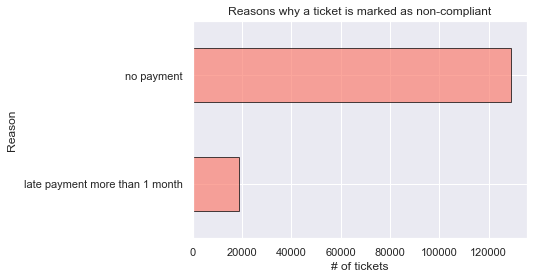

In [56]:
non_compliance = train[train['compliance'] == 0]['compliance_detail']\
                .apply(lambda x: x.replace('non-compliant by', ''))\
                .value_counts()\
                .sort_values()

print(non_compliance)
fig, ax = plt.subplots(figsize=(6,4))
non_compliance.plot.barh(ax=ax, color='salmon', edgecolor='black', alpha=0.7)
ax.set_title('Reasons why a ticket is marked as non-compliant')
ax.set_xlabel('# of tickets')
ax.set_ylabel('Reason')

The problem is more severe than I thought. A vast majority of tickets never get paid at all. 

 payment on unknown date                69
 payment with no scheduled hearing     161
 no fine                               195
 early payment                         992
 on-time payment                      3880
 late payment within 1 month          6299
Name: compliance_detail, dtype: int64


Text(0, 0.5, 'Reason')

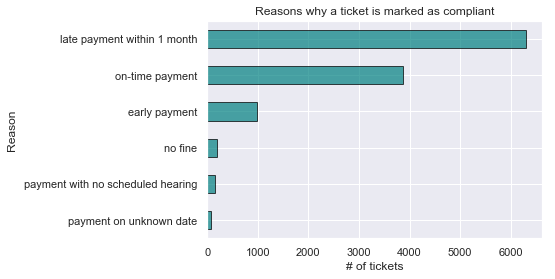

In [57]:
compliance = train[train['compliance'] == 1]['compliance_detail']\
                .apply(lambda x: x.replace('compliant by', ''))\
                .value_counts()\
                .sort_values()

print(compliance)
fig, ax = plt.subplots(figsize=(6,4))
compliance.plot.barh(ax=ax, color='teal', edgecolor='black', alpha=0.7)
ax.set_title('Reasons why a ticket is marked as compliant')
ax.set_xlabel('# of tickets')
ax.set_ylabel('Reason')

Even within the tickets marked as complied, 54% of them are paid late. Out of all the hundreds of thousands of tickets, only 992 were paid early.

### Quantitative Features

#### Dates

Before we analyze the numerical features, we can create even more aside from the ones initially provided. ticket_issued_date and hearing_date are date values. These can be expressed as numeric values if we separate them into years, months and days of the week. We can see if compliance is related to any of these. For example, in some years, violators could've been less likely to comply than in other years.  

In [58]:
for var in ['ticket_issued_date', 'hearing_date']:
    train[var+'_year'] = train[var].apply(lambda x: x.year)
    train[var+'_month'] = train[var].apply(lambda x: x.month)
    train[var+'_dayofweek'] = train[var].apply(lambda x: x.dayofweek)

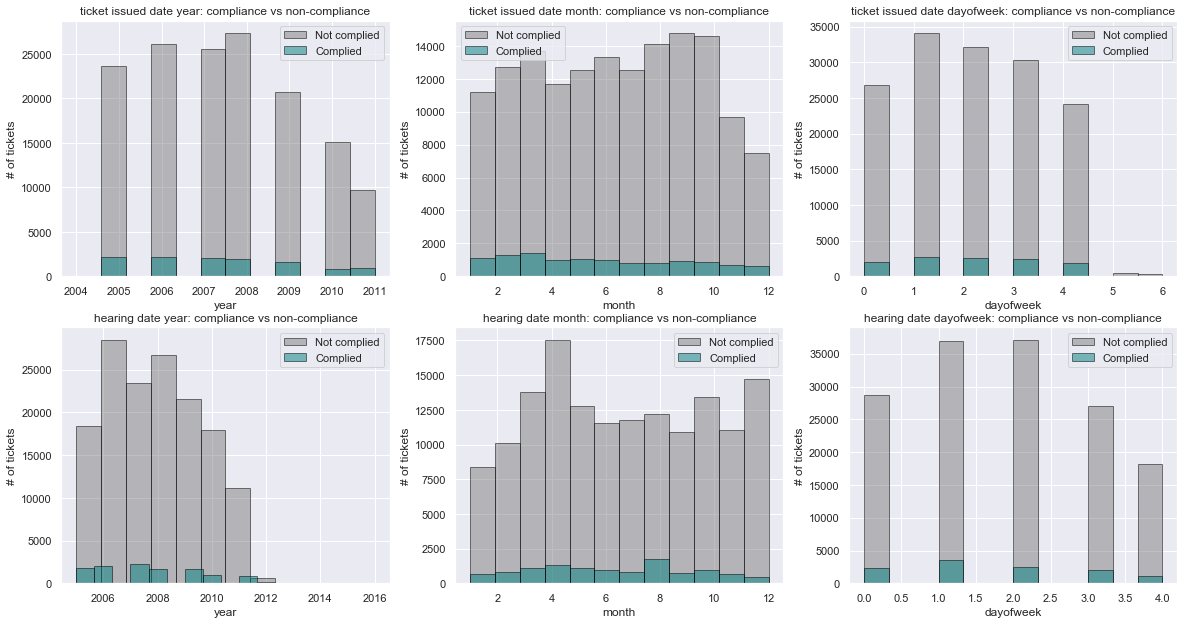

In [59]:
attributes = train.columns[-6:]
fig = plt.figure(figsize=(20,16))
for i, col in enumerate(attributes):
    ax=fig.add_subplot(330+i+1)
    ax.hist(train[train['compliance']==0][col], bins=12, alpha=0.5, color='grey', edgecolor='black', label='Not complied')
    ax.hist(train[train['compliance']==1][col], bins=12, alpha=0.5, color='teal', edgecolor='black', label ='Complied')
    ax.set_ylabel('# of tickets')
    ax.set_xlabel(col.split('_')[-1])
    ax.set_title(' '.join(col.split('_')) + ': compliance vs non-compliance')
    ax.legend()

There was an usually high rate of compliance for hearing dates in August. Aside from that, there aren't any easily discernable trends we can observe. Perhaps, we can get a more meaningful feature by calculating the difference between the hearing date and the date the ticket was issued. 

In [60]:
train['date_diff'] = train['hearing_date'] - train['ticket_issued_date']
train['date_diff'] = train['date_diff'].apply(lambda x: x.days)
train.drop(['ticket_issued_date', 'hearing_date'], axis=1, inplace=True)
train['date_diff'].describe()

count    159652.000000
mean         72.598176
std          59.498244
min        -337.000000
25%          30.000000
50%          54.000000
75%         100.000000
max        4325.000000
Name: date_diff, dtype: float64

Now, we'll plot these day differences vs. # of tickets. We'll also plot the # of tickets on a log scale to clearly see the difference in compliance.

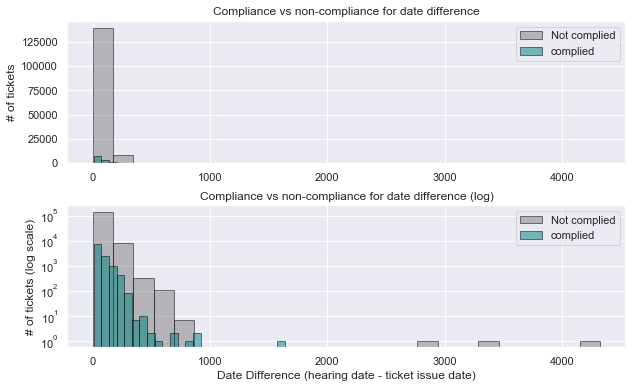

In [61]:
positive_date_diff = train[train['date_diff'] >= 0][['date_diff', 'compliance']]

fig = plt.figure(figsize=(10,6))
fig.subplots_adjust(hspace=0.3)
ax = fig.add_subplot(211)
ax.hist(positive_date_diff[positive_date_diff['compliance']==0]['date_diff'], bins=25, alpha=0.5, color='grey', edgecolor='black', label='Not complied')
ax.hist(positive_date_diff[positive_date_diff['compliance']==1]['date_diff'], bins=25, alpha=0.5, color='teal', edgecolor='black', label ='complied')
ax.set_title('Compliance vs non-compliance for date difference')
ax.set_ylabel('# of tickets')
ax.legend()

ax = fig.add_subplot(212)
ax.hist(positive_date_diff[positive_date_diff['compliance']==0]['date_diff'], bins=25, alpha=0.5, color='grey', edgecolor='black', label='Not complied', log=True)
ax.hist(positive_date_diff[positive_date_diff['compliance']==1]['date_diff'], bins=25, alpha=0.5, color='teal', edgecolor='black', label ='complied', log=True)
ax.set_title('Compliance vs non-compliance for date difference (log)')
ax.set_xlabel('Date Difference (hearing date - ticket issue date)')
ax.set_ylabel('# of tickets (log scale)')
ax.legend()

There seems to be more compliance when the the ticket issue date and the hearing date aren't far apart. However, non-compliance is still the norm across the entire distribution.

#### Fines and Fees

We plot histograms for all the fines and fees. Since we have outliers and a large number of non-compliances in comparison to compliances, we'd have extremely right-skewed distributions. To make distributions clearer, we'll once again apply a log scale to the # of tickets.

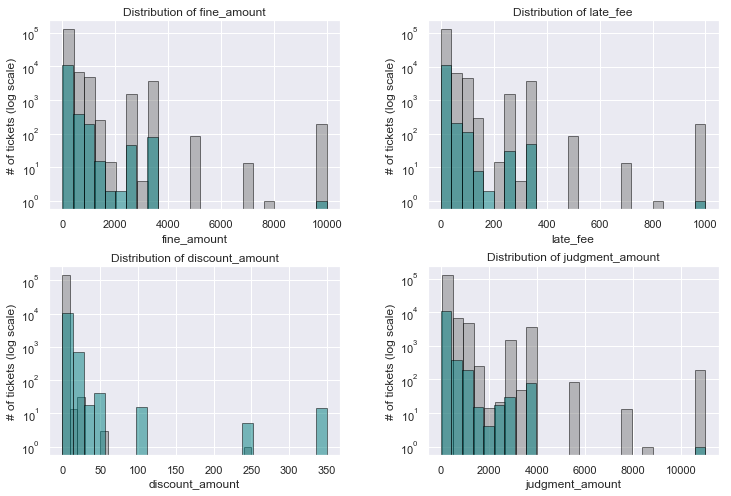

In [62]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace = .3, wspace=0.3)
attributes = ['fine_amount', 'late_fee', 'discount_amount', 'judgment_amount']
for i, col in enumerate(attributes):
    ax = fig.add_subplot(220+i+1)
    ax.hist(train[(train['compliance']==0)][col], bins=25, edgecolor='black', alpha=0.5, color='grey', log=True)
    ax.hist(train[(train['compliance']==1)][col], bins=25, edgecolor='black', alpha=0.5, color='teal', log=True)
    ax.set_title('Distribution of ' + col)
    ax.set_ylabel('# of tickets (log scale)')
    ax.set_xlabel(col)

We can see less compliance rate for larger fine and judgment amounts. We can also see that compliance outnumbers non-compliance in the case where there's a discount amount. This makes sense since you'll only receive a discount if you pay early.

#### Latitude and Longitude

The dataset covers some non-Detroit addresses, but they're very few. We'll restrict the latitude and longitude to only reflect the Detroit area, just for the sake of visualization.

(42.2, 42.5)

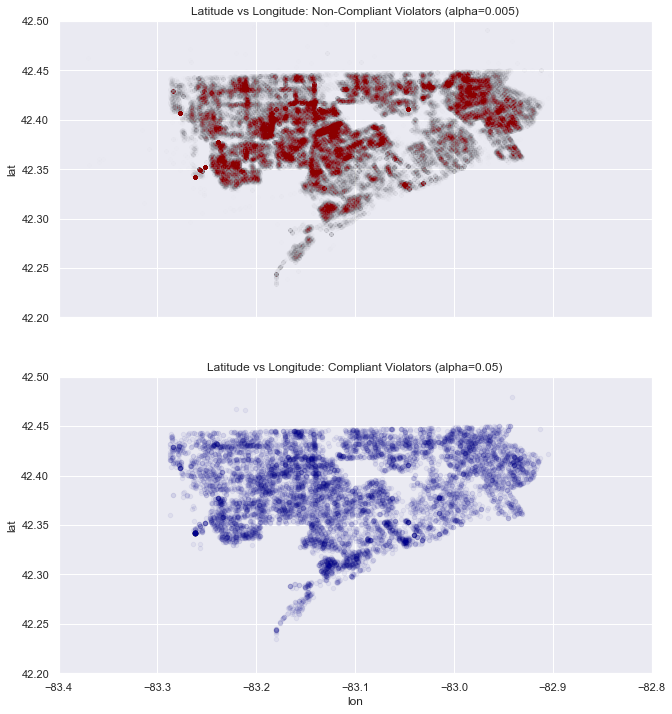

In [63]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211, aspect='equal')
train.plot(kind='scatter', x='lon', y='lat', ax=ax1, alpha=0.005, c='darkred')
ax1.set_title('Latitude vs Longitude: Non-Compliant Violators (alpha=0.005)')
ax1.set_xlim(-83.4, -82.8)
ax1.set_ylim(42.2, 42.5)

ax2 = fig.add_subplot(212, aspect='equal',  sharex=ax1)
train[train['compliance'] == 1].plot(kind='scatter', x='lon', y='lat', ax=ax2, alpha=0.05, c='darkblue')
ax2.set_title('Latitude vs Longitude: Compliant Violators (alpha=0.05)')
ax2.set_xlim(-83.4, -82.8)
ax2.set_ylim(42.2, 42.5)

In [77]:
train.drop(['violation_street_number', 'violation_street_name'], axis=1, inplace=True)

### Qualitative Features

#### Agency Name

In [64]:
train.agency_name.value_counts()

Buildings, Safety Engineering & Env Department    95863
Department of Public Works                        52445
Health Department                                  7107
Detroit Police Department                          4463
Neighborhood City Halls                               1
Name: agency_name, dtype: int64

Taking a look at the value counts for agency name, it seems like a great feature to one-hot encode. We'll get rid of Neighborhood City Halls since it only has 1 observation.

In [65]:
train = train[train['agency_name'] != 'Neighborhood City Halls']

compliance                                        0.0   1.0  compliance_rate
agency_name                                                                 
Detroit Police Department                        3876   587        13.152588
Health Department                                6639   468         6.585057
Department of Public Works                      47727  4718         8.996091
Buildings, Safety Engineering & Env Department  90040  5823         6.074294


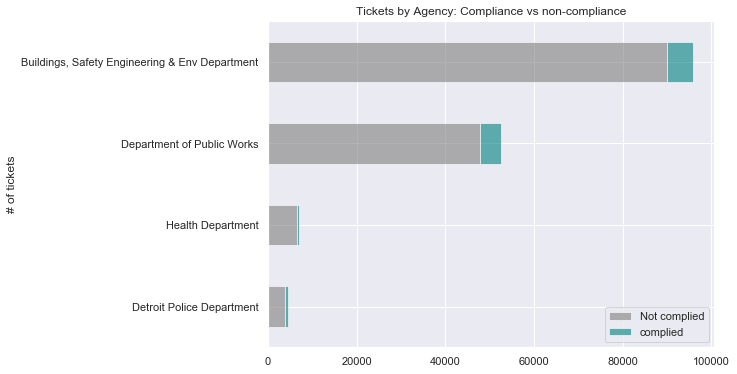

In [66]:
agency = train.groupby(['agency_name', 'compliance'])['compliance'].count().unstack().sort_values(0)
fig, ax = plt.subplots(figsize=(8,6))
agency.plot(kind='barh', stacked=True, color=['grey', 'teal'], ax=ax, alpha=0.6)
ax.set_ylabel('# of tickets')
ax.set_title('Tickets by Agency: Compliance vs non-compliance')
ax.legend(['Not complied', 'complied'])
agency['compliance_rate'] = agency[1]/(agency[1] + agency[0])*100
print(agency)

The Buildings Department issues by far the most blight tickets, but it has the lowest compliance rate out of the 4 agencies. Tickets issued by the Health Department have the greatest compliance rate (13%).

#### Disposition

In [67]:
train.disposition.value_counts()

Responsible by Default                138339
Responsible by Admission               13701
Responsible by Determination            7643
Responsible (Fine Waived) by Deter       195
Name: disposition, dtype: int64

compliance                               0.0     1.0  disposition_rate
disposition                                                           
Responsible (Fine Waived) by Deter       0.0   195.0        100.000000
Responsible by Determination          5294.0  2349.0         30.734005
Responsible by Admission              9933.0  3768.0         27.501642
Responsible by Default              133055.0  5284.0          3.819603


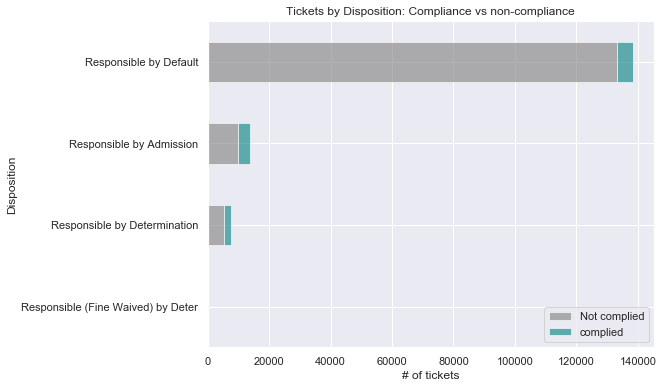

In [68]:
disposition = train.groupby(['disposition', 'compliance'])['compliance'].count().unstack().fillna(0).sort_values(0)
fig, ax = plt.subplots(figsize=(8,6))
disposition.plot(kind='barh', stacked=True, color=['grey', 'teal'], ax=ax, alpha=0.6)
ax.set_ylabel('Disposition')
ax.set_xlabel('# of tickets')
ax.set_title('Tickets by Disposition: Compliance vs non-compliance')
ax.legend(['Not complied', 'complied'], loc='lower right')
disposition['disposition_rate'] = disposition[1]/(disposition[1] + disposition[0])*100
print(disposition)

Those responsible by admission and determination have a relatively high compliance rate, while those responsible by default are very unlikely to comply.

#### Violation Code

In [69]:
train.violation_code.value_counts()

9-1-36(a)               64414
9-1-81(a)               23145
22-2-88                 19073
9-1-104                 16927
22-2-88(b)               4879
22-2-45                  4200
9-1-105                  3619
9-1-110(a)               3146
9-1-43(a) - (Dwellin     3043
9-1-103(C)               2641
22-2-22                  2612
22-2-43                  2054
19450901                 1620
22-2-17                  1414
22-2-61                   706
22-2-83(a)(b)(c)          494
9-1-82(d) - (Dwellin      457
61-81.0100/32.0066        439
9-1-43(a) - (Structu      399
22-2-83                   346
22-2-88(a)                235
9-1-206                   235
61-5-21                   202
9-1-209                   200
22-2-21(b)                185
9-1-101                   150
9-1-107                   133
9-1-43(a) - (Stories      132
9-1-111                   130
9-1-201(a)                128
                        ...  
61-4-35                     1
9-1-502                     1
9-1-474   

We see a total of 189 violation codes. We don't want to one-hot encode them yet, or else we'll end up with more than 200 features. We can group them by the first 2 characters.

In [70]:
train['violation_code'] = train['violation_code'].apply(lambda x: x[:2])
train['violation_code'].value_counts()

9-    119935
22     36990
19      1649
61      1210
20        94
Name: violation_code, dtype: int64

Much better. However, we do not know whether codes that start with the same numbers have a relationship. I wasn't able to find information online about violation codes, so we'll just keep these categories, use them to fit our model and evalute whether they're important later.

compliance         0.0   1.0  disposition_rate
violation_code                                
20                  89     5          5.319149
61                1058   152         12.561983
19                1599    50          3.032141
22               33832  3158          8.537443
9-              111704  8231          6.862884


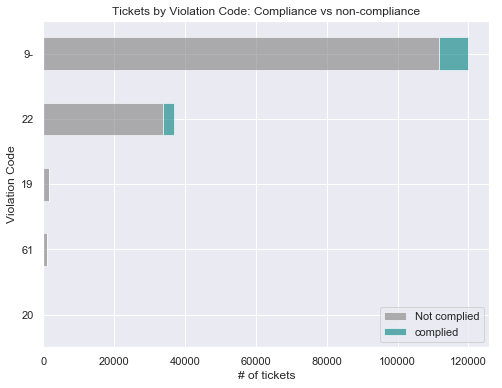

In [71]:
code = train.groupby(['violation_code', 'compliance'])['compliance'].count().unstack().fillna(0).sort_values(0)
fig, ax = plt.subplots(figsize=(8,6))
code.plot(kind='barh', stacked=True, color=['grey', 'teal'], ax=ax, alpha=0.6)
ax.set_ylabel('Violation Code')
ax.set_xlabel('# of tickets')
ax.set_title('Tickets by Violation Code: Compliance vs non-compliance')
ax.legend(['Not complied', 'complied'], loc='lower right')
code['disposition_rate'] = code[1]/(code[1] + code[0])*100
print(code)

violation_description column simply describes the violation code, so I'll drop that column.

In [72]:
train.drop(['violation_description'], 
           axis=1, inplace=True)

#### Mailing Address

The dataset also contains information about the violator's mailing address. We could turn this information into a feature. Since the majority of the addresses are from Michigan, we'll have a column that tells us whether a violator's mailing address is from Michigan or not.

In [73]:
train['Michigan'] = train['state'].apply(lambda x: 1 if x == 'MI' else 0)
train.drop(['mailing_address_str_number', 'mailing_address_str_name', 'city', 'state', 'zip_code', 'country'], axis=1, inplace=True)

compliance     0.0    1.0  disposition_rate
Michigan                                   
0            15223   1002          6.175655
1           133059  10594          7.374715


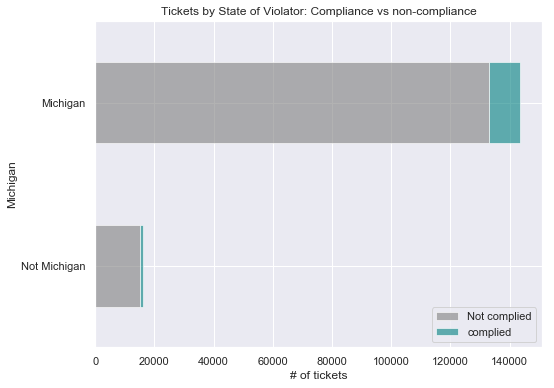

In [74]:
michigan = train.groupby(['Michigan', 'compliance'])['compliance'].count().unstack().fillna(0).sort_values(0)
fig, ax = plt.subplots(figsize=(8,6))
michigan.plot(kind='barh', stacked=True, color=['grey', 'teal'], ax=ax, alpha=0.6)
ax.set_xlabel('# of tickets')
ax.set_title('Tickets by State of Violator: Compliance vs non-compliance')
ax.set_yticklabels(['Not Michigan', 'Michigan'])
ax.legend(['Not complied', 'complied'], loc='lower right')
michigan['disposition_rate'] = michigan[1]/(michigan[1] + michigan[0])*100
print(michigan)

violator_name and inspector_name have too many unique values to serve as useful predictors, so I'll drop them.

In [78]:
train.drop(['inspector_name', 'violator_name'], axis=1, inplace=True)

#### Remaining columns

The remaining columns, as stated by the assignment, will not be available during evaluation, so I'll get rid of them.

In [79]:
train.drop(['compliance_detail', 'payment_status', 'balance_due', 'payment_amount'], 
           axis=1, inplace=True)

## Machine Learning

### Preparing Our Model

We are left with 3 categorical features, which we'll have to one-hot encode for our model.

In [80]:
attributes = ['disposition', 'agency_name', 'violation_code']
for col in attributes:
    dummies = pd.get_dummies(train[col], prefix=col)
    train = pd.concat([train, dummies], axis=1)
train.drop(attributes, axis=1, inplace=True)

Now let's split the data into the features and the target

In [81]:
features = train.drop(columns='compliance')
target = pd.DataFrame(train['compliance'])

print('Features:', features.shape[1])
print('Observations:', features.shape[0])

Features: 27
Observations: 159878


We have a total of 27 features and 159878 observations. We split them into training and test sets using a 70-30 split.

In [82]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(features, target, test_size =0.3, random_state=1)
print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(111914, 27)
(47964, 27)
(111914, 1)
(47964, 1)


We still have some missing values for the features related to the hearing dates. We will fill these values with the median of all the other values in each feature.

In [83]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')
imputer.fit(X)
X = imputer.transform(X)
X_test = imputer.transform(X_test)

### Model Evaluation

We'll try out 4 different methods: Logistic Regression, Decision Trees, Random Forests and Gradient Boosting. I'll avoid support vector machines as their performance can be slow for big datasets such as this one. I'll also avoid K-Nearest Neighbors since its performance can be slow for datasets with a lot of features.

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

#### Logistic Regression

In [85]:
lreg = LogisticRegression()
lreg.fit(X, y)
print('AUC:', roc_auc_score(y_test, lreg.predict_proba(X_test)[:,1]))

AUC: 0.802058298545791


Not bad at all, but this is only a validation set. Let's see how it does for other models.

#### Decision Tree

In [86]:
dtree = DecisionTreeClassifier()
dtree.fit(X, y)

print('AUC:', roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))

AUC: 0.7030687005266287


The baseline score for decision tree is not great. We'll do some hyperparameter tuning to see if we can increase it. First, we'll plot the AUC of various hyperparameters, so we can get an idea of which hyperparameter ranges to try later on.

Max_depth: 8
Max AUC (test): 0.8177994585882472
min_samples_split: 30
Max AUC (test): 0.7672059878663344
min_weight_fraction_leaf: 0.1111111111111111
Max AUC (test): 0.7829361686912195
max_leaf_nodes: 18
Max AUC (test): 0.7923220872927051
criterion: gini
Max AUC (test): 0.7022332408583445
min_samples_leafs: 20
Max AUC (test): 0.7903322431356915


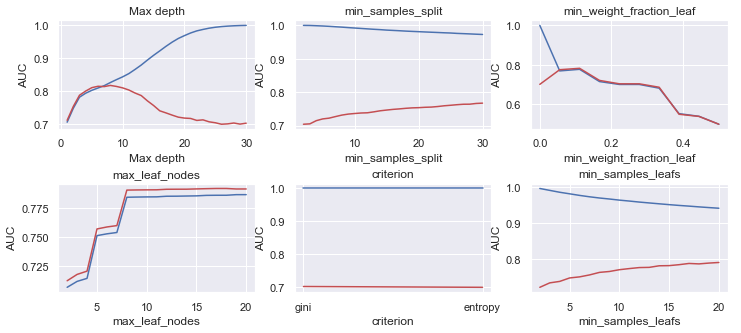

In [101]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace = .5)

max_depths = np.arange(1,31)
train_results = []
test_results = []
for max_depth in max_depths:
    dtree = DecisionTreeClassifier(max_depth=max_depth)
    dtree.fit(X, y)
    train_results.append(roc_auc_score(y, dtree.predict_proba(X)[:,1]))
    test_results.append(roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))
    
ax1 = fig.add_subplot(331)
line1, = ax1.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = ax1.plot(max_depths, test_results, 'r', label='Test AUC')
ax1.set_ylabel('AUC')
ax1.set_xlabel('Max depth')
ax1.set_title('Max depth')

print('Max_depth:', max_depths[np.array(test_results).argmax()])
print('Max AUC (test):', max(test_results))

min_samples_splits = range(2,31)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dtree = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dtree.fit(X, y)
    train_results.append(roc_auc_score(y, dtree.predict_proba(X)[:,1]))
    test_results.append(roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))
ax2 = fig.add_subplot(332)
line1, = ax2.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = ax2.plot(min_samples_splits, test_results, 'r', label='Test AUC')
ax2.set_ylabel('AUC')
ax2.set_xlabel('min_samples_split')
ax2.set_title('min_samples_split')

print('min_samples_split:', min_samples_splits[np.array(test_results).argmax()])
print('Max AUC (test):', max(test_results))

min_weight_fraction_leafs = np.linspace(0,0.5,10)
train_results = []
test_results = []
for min_weight_fraction_leaf in min_weight_fraction_leafs:
    dtree = DecisionTreeClassifier(min_weight_fraction_leaf=min_weight_fraction_leaf)
    dtree.fit(X, y)
    train_results.append(roc_auc_score(y, dtree.predict_proba(X)[:,1]))
    test_results.append(roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))
ax3 = fig.add_subplot(333)
line1, = ax3.plot(min_weight_fraction_leafs, train_results, 'b', label='Train AUC')
line2, = ax3.plot(min_weight_fraction_leafs, test_results, 'r', label='Test AUC')
ax3.set_ylabel('AUC')
ax3.set_xlabel('min_weight_fraction_leaf')
ax3.set_title('min_weight_fraction_leaf')

print('min_weight_fraction_leaf:', min_weight_fraction_leafs[np.array(test_results).argmax()])
print('Max AUC (test):', max(test_results))

max_leaf_nodes = range(2,21)
train_results = []
test_results = []
for max_leaf_node in max_leaf_nodes:
    dtree = DecisionTreeClassifier(max_leaf_nodes=max_leaf_node)
    dtree.fit(X, y)
    train_results.append(roc_auc_score(y, dtree.predict_proba(X)[:,1]))
    test_results.append(roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))
ax4 = fig.add_subplot(334)
line1, = ax4.plot(max_leaf_nodes, train_results, 'b', label='Train AUC')
line2, = ax4.plot(max_leaf_nodes, test_results, 'r', label='Test AUC')
ax4.set_ylabel('AUC')
ax4.set_xlabel('max_leaf_nodes')
ax4.set_title('max_leaf_nodes')

print('max_leaf_nodes:', max_leaf_nodes[np.array(test_results).argmax()])
print('Max AUC (test):', max(test_results))

criterions = ['gini', 'entropy']
train_results = []
test_results = []
for criterion in criterions:
    dtree = DecisionTreeClassifier(criterion=criterion)
    dtree.fit(X, y)
    train_results.append(roc_auc_score(y, dtree.predict_proba(X)[:,1]))
    test_results.append(roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))
ax5 = fig.add_subplot(335)
line1, = ax5.plot(criterions, train_results, 'b', label='Train AUC')
line2, = ax5.plot(criterions, test_results, 'r', label='Test AUC')
ax5.set_ylabel('AUC')
ax5.set_xlabel('criterion')
ax5.set_title('criterion')

print('criterion:', criterions[np.array(test_results).argmax()])
print('Max AUC (test):', max(test_results))

min_samples_leafs = range(2,21)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dtree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dtree.fit(X, y)
    train_results.append(roc_auc_score(y, dtree.predict_proba(X)[:,1]))
    test_results.append(roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))
ax6 = fig.add_subplot(336)
line1, = ax6.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = ax6.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
ax6.set_ylabel('AUC')
ax6.set_xlabel('min_samples_leafs')
ax6.set_title('min_samples_leafs')

print('min_samples_leafs:', min_samples_leafs[np.array(test_results).argmax()])
print('Max AUC (test):', max(test_results))

Next, we utilize RandomizedSearchCV to see which combinations of hyperparameters work best on a sample of 500 candidates. We'll repeat this process for the remaining models as well. Even though, I would've liked to perform a GridSearch too, the model fits are taking a lot of time, so we'll have to settle for only trying a subset of all the hyperparameter combinations, for now.

In [518]:
min_samples_split = np.arange(2,31)

min_samples_leaf = np.arange(2,31)

max_depth = np.arange(1, 15)

param_grid = {
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_depth': max_depth
}

model = DecisionTreeClassifier(random_state=42)
random_cv = RandomizedSearchCV(estimator=model,
                                param_distributions=param_grid,
                                cv=4, n_iter=500,
                               scoring='roc_auc',
                               n_jobs=-1, verbose = 1, 
                               return_train_score = True,
                               random_state=42
                              )
random_cv.fit(X, y)

Fitting 4 folds for each of 500 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  3.7min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=500, n_jobs=-1,
          param_distributions={'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), 'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=Tru

In [519]:
print('AUC:', roc_auc_score(y_test, random_cv.predict_proba(X_test)[:,1]))
random_cv.best_params_

AUC: 0.8223599649895472


{'min_samples_split': 24, 'min_samples_leaf': 30, 'max_depth': 9}

### Random Forest

In [87]:
dtree = RandomForestClassifier()
dtree.fit(X, y)

print('AUC:', roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))

AUC: 0.8067252445686652


Max_depth: 16
Max AUC (test): 0.8400609805128326
min_samples_split: 27
Max AUC (test): 0.8405573523692141
min_weight_fraction_leaf: 0.0
Max AUC (test): 0.798183746965001
max_leaf_nodes: 18
Max AUC (test): 0.8161728310995808
n_estimators: 200
Max AUC (test): 0.8438915294233752
min_samples_leafs: 20
Max AUC (test): 0.8407815413186821


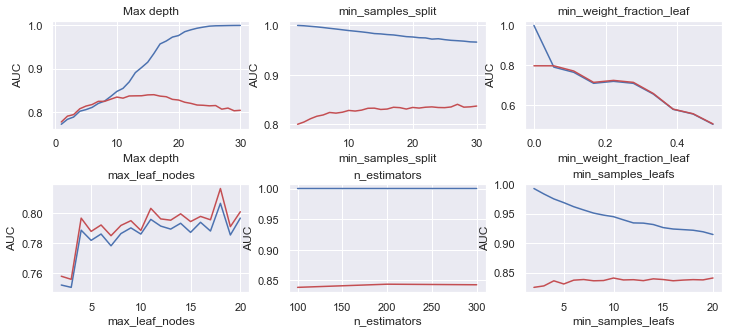

In [521]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace = .5)

max_depths = np.arange(1,31)
train_results = []
test_results = []
for max_depth in max_depths:
    dtree = RandomForestClassifier(max_depth=max_depth)
    dtree.fit(X, y)
    train_results.append(roc_auc_score(y, dtree.predict_proba(X)[:,1]))
    test_results.append(roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))
    
ax1 = fig.add_subplot(331)
line1, = ax1.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = ax1.plot(max_depths, test_results, 'r', label='Test AUC')
ax1.set_ylabel('AUC')
ax1.set_xlabel('Max depth')
ax1.set_title('Max depth')

print('Max_depth:', max_depths[np.array(test_results).argmax()])
print('Max AUC (test):', max(test_results))

min_samples_splits = range(2,31)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dtree = RandomForestClassifier(min_samples_split=min_samples_split)
    dtree.fit(X, y)
    train_results.append(roc_auc_score(y, dtree.predict_proba(X)[:,1]))
    test_results.append(roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))
ax2 = fig.add_subplot(332)
line1, = ax2.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = ax2.plot(min_samples_splits, test_results, 'r', label='Test AUC')
ax2.set_ylabel('AUC')
ax2.set_xlabel('min_samples_split')
ax2.set_title('min_samples_split')

print('min_samples_split:', min_samples_splits[np.array(test_results).argmax()])
print('Max AUC (test):', max(test_results))

min_weight_fraction_leafs = np.linspace(0,0.5,10)
train_results = []
test_results = []
for min_weight_fraction_leaf in min_weight_fraction_leafs:
    dtree = RandomForestClassifier(min_weight_fraction_leaf=min_weight_fraction_leaf)
    dtree.fit(X, y)
    train_results.append(roc_auc_score(y, dtree.predict_proba(X)[:,1]))
    test_results.append(roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))
ax3 = fig.add_subplot(333)
line1, = ax3.plot(min_weight_fraction_leafs, train_results, 'b', label='Train AUC')
line2, = ax3.plot(min_weight_fraction_leafs, test_results, 'r', label='Test AUC')
ax3.set_ylabel('AUC')
ax3.set_xlabel('min_weight_fraction_leaf')
ax3.set_title('min_weight_fraction_leaf')

print('min_weight_fraction_leaf:', min_weight_fraction_leafs[np.array(test_results).argmax()])
print('Max AUC (test):', max(test_results))

max_leaf_nodes = range(2,21)
train_results = []
test_results = []
for max_leaf_node in max_leaf_nodes:
    dtree = RandomForestClassifier(max_leaf_nodes=max_leaf_node)
    dtree.fit(X, y)
    train_results.append(roc_auc_score(y, dtree.predict_proba(X)[:,1]))
    test_results.append(roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))
ax4 = fig.add_subplot(334)
line1, = ax4.plot(max_leaf_nodes, train_results, 'b', label='Train AUC')
line2, = ax4.plot(max_leaf_nodes, test_results, 'r', label='Test AUC')
ax4.set_ylabel('AUC')
ax4.set_xlabel('max_leaf_nodes')
ax4.set_title('max_leaf_nodes')

print('max_leaf_nodes:', max_leaf_nodes[np.array(test_results).argmax()])
print('Max AUC (test):', max(test_results))

n_estimators = [100, 200, 300]
train_results = []
test_results = []
for n_estimator in n_estimators:
    dtree = RandomForestClassifier(n_estimators=n_estimator)
    dtree.fit(X, y)
    train_results.append(roc_auc_score(y, dtree.predict_proba(X)[:,1]))
    test_results.append(roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))
ax5 = fig.add_subplot(335)
line1, = ax5.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = ax5.plot(n_estimators, test_results, 'r', label='Test AUC')
ax5.set_ylabel('AUC')
ax5.set_xlabel('n_estimators')
ax5.set_title('n_estimators')

print('n_estimators:', n_estimators[np.array(test_results).argmax()])
print('Max AUC (test):', max(test_results))

min_samples_leafs = range(2,21)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dtree = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    dtree.fit(X, y)
    train_results.append(roc_auc_score(y, dtree.predict_proba(X)[:,1]))
    test_results.append(roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))
ax6 = fig.add_subplot(336)
line1, = ax6.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = ax6.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
ax6.set_ylabel('AUC')
ax6.set_xlabel('min_samples_leafs')
ax6.set_title('min_samples_leafs')

print('min_samples_leafs:', min_samples_leafs[np.array(test_results).argmax()])
print('Max AUC (test):', max(test_results))

In [89]:
min_samples_split = np.arange(2,41)

min_samples_leaf = np.arange(2,31)

max_depth = np.arange(2,31)

n_estimators = [100, 300, 500]

param_grid = {'n_estimators': n_estimators,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_depth': max_depth
}

model = RandomForestClassifier(random_state=42)
random_cv = RandomizedSearchCV(estimator=model,
                                param_distributions=param_grid,
                                cv=4, n_iter=25,
                               scoring='roc_auc',
                               n_jobs=-1, verbose = 1, 
                               return_train_score = True,
                               random_state=42
                              )
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.8min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=25, n_jobs=-1,
          param_distributions={'n_estimators': [100, 300, 500], 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40]), 'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), 'max_depth': array([ 2,  4,  6

In [90]:
print('AUC:', roc_auc_score(y_test, random_cv.predict_proba(X_test)[:,1]))
random_cv.best_params_

AUC: 0.8530302932851219


{'n_estimators': 500,
 'min_samples_split': 14,
 'min_samples_leaf': 7,
 'max_depth': 28}

#### Gradient Boosting

In [97]:
dtree = GradientBoostingClassifier()
dtree.fit(X, y)

print('AUC:', roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1]))

AUC: 0.8296885371070606


In [103]:
min_samples_split = np.arange(2,41)

min_samples_leaf = np.arange(2,31)

max_depth = np.arange(2,31)

learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

n_estimators = [100, 300, 500]

param_grid = {'n_estimators': n_estimators,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_depth': max_depth,
              'learning_rate': learning_rate
}

model = GradientBoostingClassifier(random_state=42)
random_cv = RandomizedSearchCV(estimator=model,
                                param_distributions=param_grid,
                                cv=4, n_iter=25,
                               scoring='roc_auc',
                               n_jobs=-1, verbose = 1, 
                               return_train_score = True,
                               random_state=42
                              )
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 236.3min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=25, n_jobs=-1,
          param_distributions={'n_estimators': [100, 300, 500], 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40]), 'min_samples_leaf': array([ 2,  3,  4,  5,  6,... 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), 'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01]},
          pre_dispatch='2*n_jobs', random_state=42,

In [104]:
print('AUC:', roc_auc_score(y_test, random_cv.predict_proba(X_test)[:,1]))
random_cv.best_params_

AUC: 0.8525084865061825


{'n_estimators': 300,
 'min_samples_split': 4,
 'min_samples_leaf': 12,
 'max_depth': 10,
 'learning_rate': 0.05}

### Evaluation on the Test Set

I submitted all 4 models for the assignment. In the end, random forest classifier yielded the best score: 0.811011978939. A pretty good score I would say. The other models didn't do that bad either. Let's plot their scores.

Text(0.5, 1.0, 'Model Comparison on AUC')

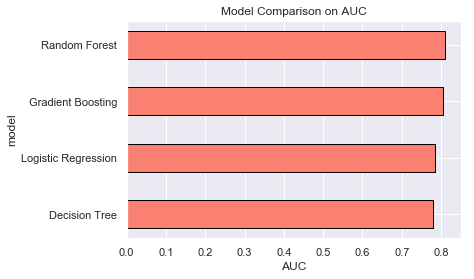

In [125]:
scores = [0.779857455253, 0.783339601801, 0.80456096727, 0.811011978939]
models = ['Decision Tree', 'Logistic Regression', 'Gradient Boosting', 'Random Forest']

plt.barh(models, scores, height=0.5, color='salmon', edgecolor='black')
plt.xlabel('AUC')
plt.ylabel('model')
plt.title('Model Comparison on AUC')

## Conclusion

Thanks to this project, I was able to put into practice various machine learning techniques for the first time, such as hyperparameter tuning, cross-validation and imputing. In the end, I managed to get a great AUC score of 0.811. While I'm satisfied with this score, I still think I could've acheived a better score. After all the maximum score anyone has ever acheived was [0.83392](https://www.kaggle.com/c/detroit-blight-ticket-compliance/leaderboard). I could've reduced the number of features, tested out more hypterparameter combinations, or even tried other models such as neural networks. For now, I'd rather focus on developing my base machine learning skills, and hopefully, come back to this problem later.    